## Necessary / Mandatory Imports 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# To show images inside the Notebook
% matplotlib inline 

## Calibrating Camera 
> We need to calibrate camera for undistorting images. We need to do it once for a camera 

To calibrate camera, one common technique is to use a chessboard and take multiple pictures of it and then use opencv's  `findChessBoardCorners` and use that to further undistort the camera

Worked for : output_images/calibrated8.jpg
Worked for : output_images/calibrated7.jpg
Worked for : output_images/calibrated18.jpg
Worked for : output_images/calibrated14.jpg
Worked for : output_images/calibrated2.jpg
Worked for : output_images/calibrated10.jpg
Unable to find Points for camera_cal/calibration4.jpg
Worked for : output_images/calibrated19.jpg
Worked for : output_images/calibrated13.jpg
Worked for : output_images/calibrated20.jpg
Worked for : output_images/calibrated9.jpg
Worked for : output_images/calibrated16.jpg
Worked for : output_images/calibrated15.jpg
Worked for : output_images/calibrated11.jpg
Unable to find Points for camera_cal/calibration1.jpg
Worked for : output_images/calibrated17.jpg
Worked for : output_images/calibrated6.jpg
Worked for : output_images/calibrated3.jpg
Worked for : output_images/calibrated12.jpg
Unable to find Points for camera_cal/calibration5.jpg


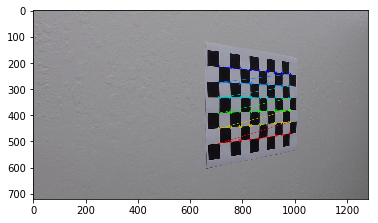

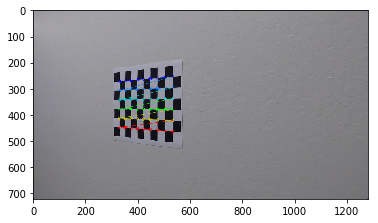

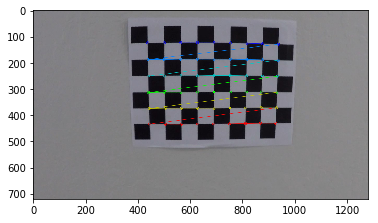

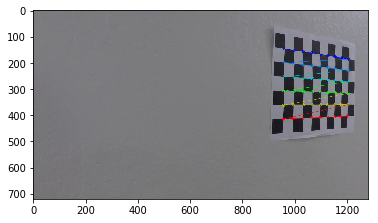

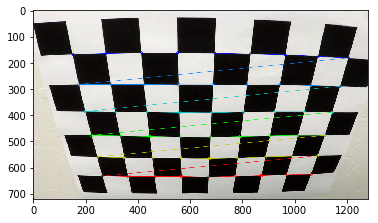

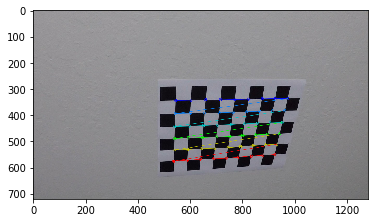

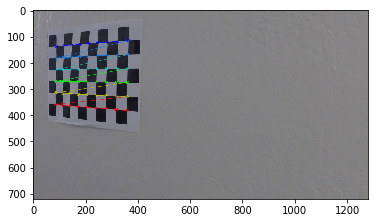

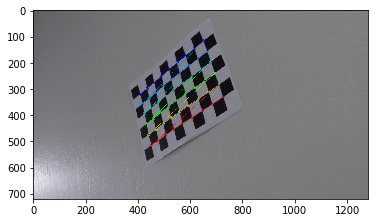

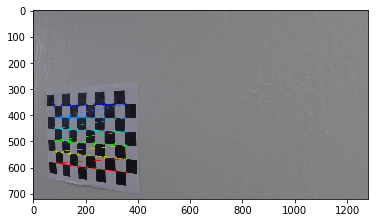

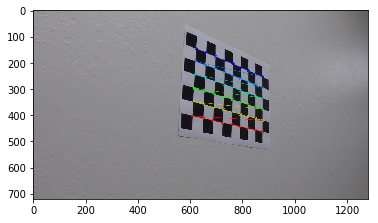

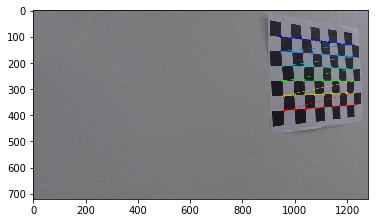

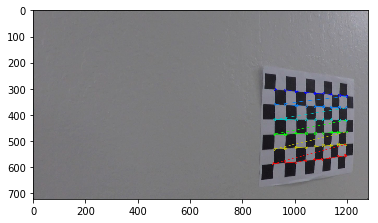

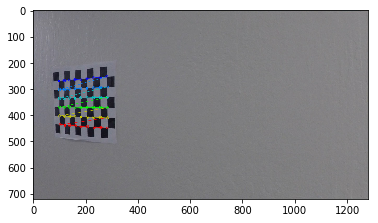

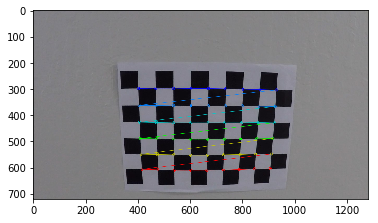

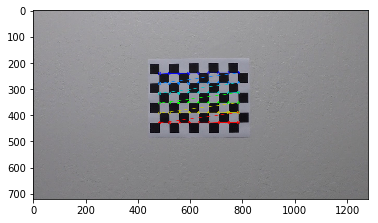

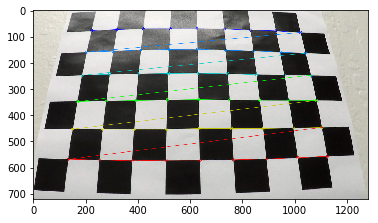

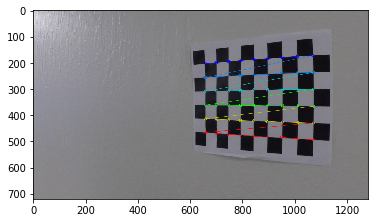

In [2]:
import os
import glob # Wildcards *_*

objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []
failed_images = []
nx = 9 # No of horizontal centers in the chessboard
ny = 6 # No of vertical centers in the chessboard
images = glob.glob('camera_cal/calibration*.jpg')
# Show images in Native Windows instead of drawing them in browsers
%matplotlib inline
for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    # If found, add object points and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw the chessboardCorners
        cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        target_name = "output_images/"  + os.path.basename(image).replace("calibration","calibrated")
        print("Worked for : " + target_name)
        plt.figure()
        plt.imshow(img)
        #cv2.imwrite(target_image,img)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
    else:
        print("Unable to find Points for " + image)
        failed_images.append(image)


## Hmm, our function fails for these three images. Let's see what's wrong


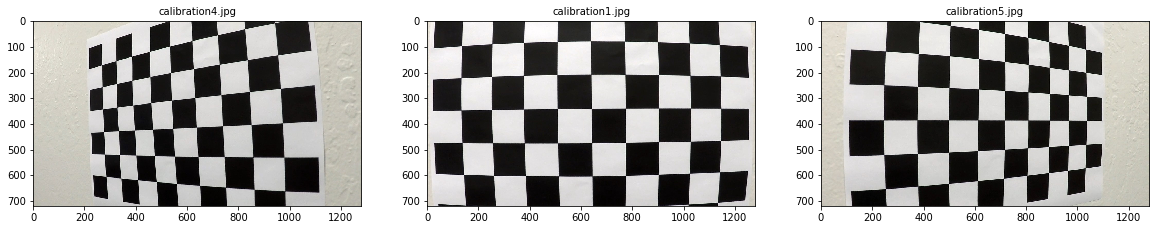

In [3]:
f, axes = plt.subplots(1, len(failed_images), figsize=(20,10))
for index in range(0,len(axes)):
    img_path = failed_images[index]
    axis = axes[index]
    axis.set_title(os.path.basename(img_path),fontsize=10)
    axis.imshow(mpimg.imread(img_path))

## Oh they are cropped and varies from 9 X 5 to 8 X 5, Let's skip them,since then image and object points would be different

# Undistorting
Let's test distortion on of the images and then use that to calibrate cameras

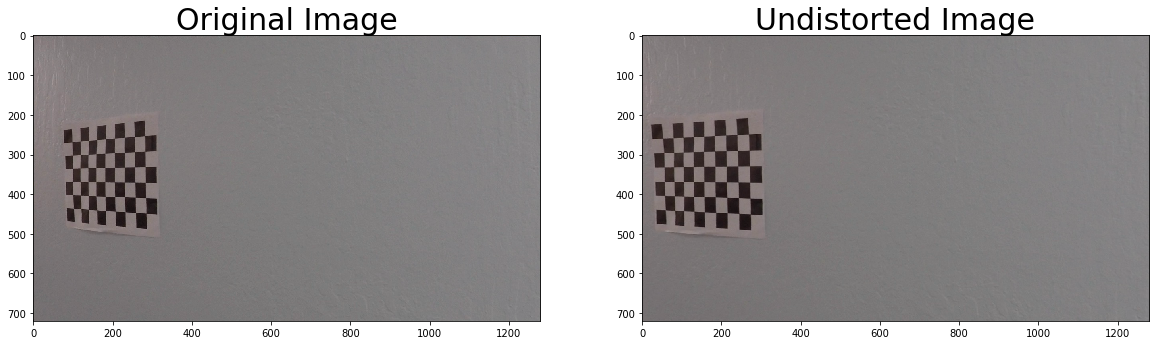

In [18]:
import pickle
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Let's test them on the Lane images now 

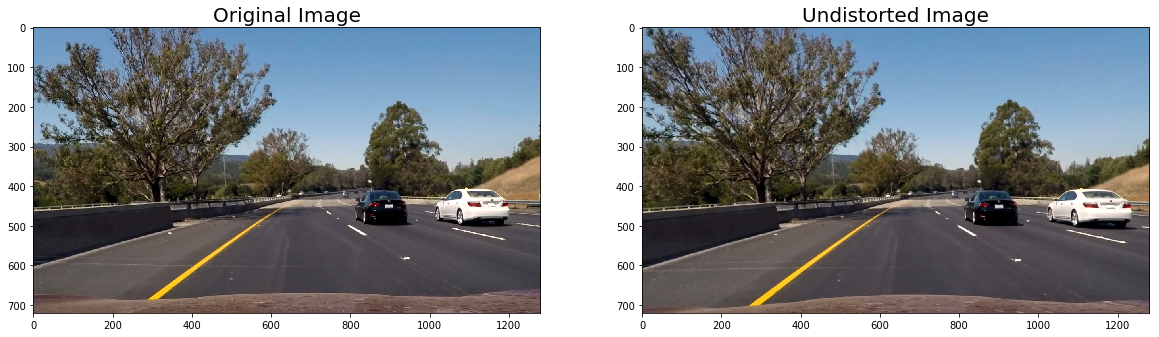

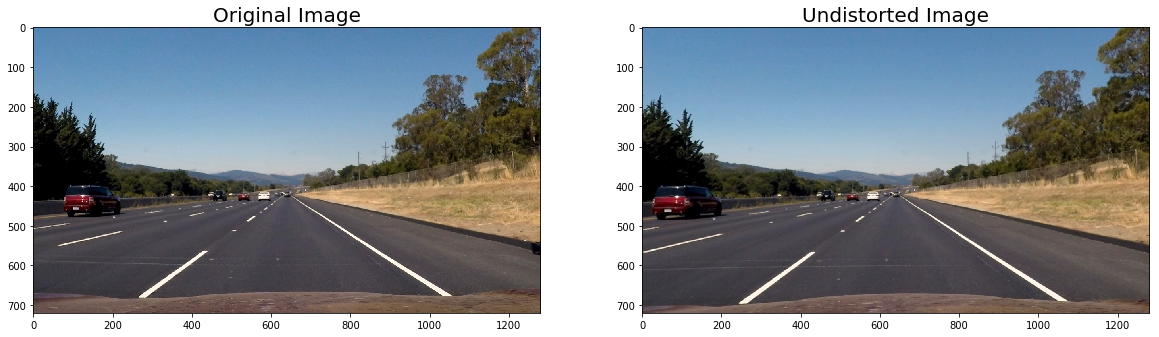

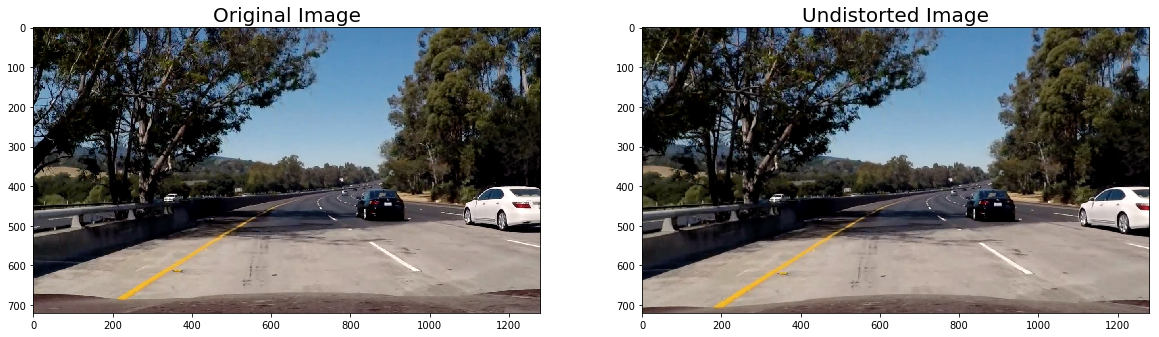

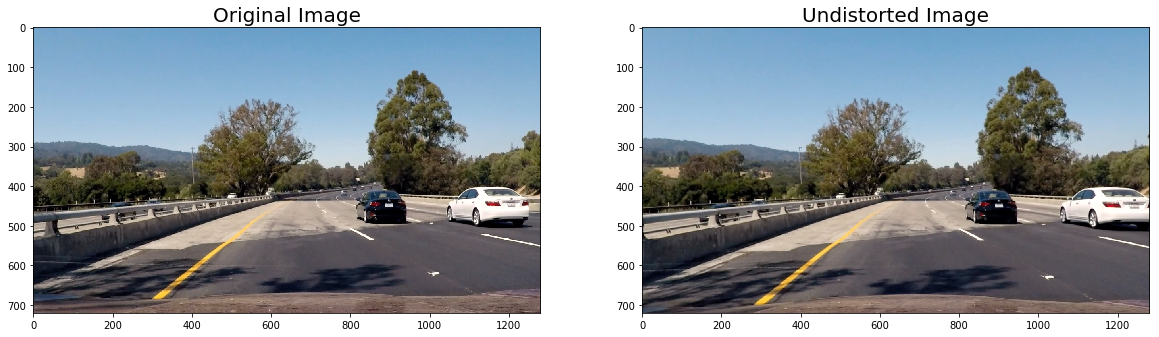

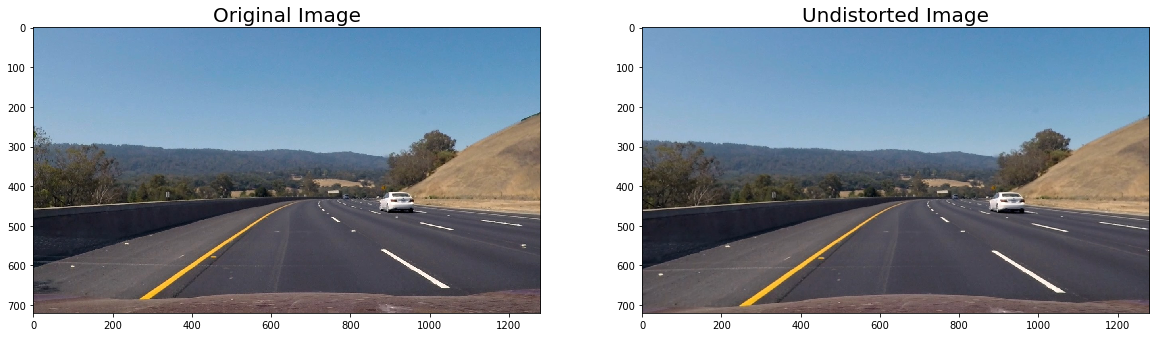

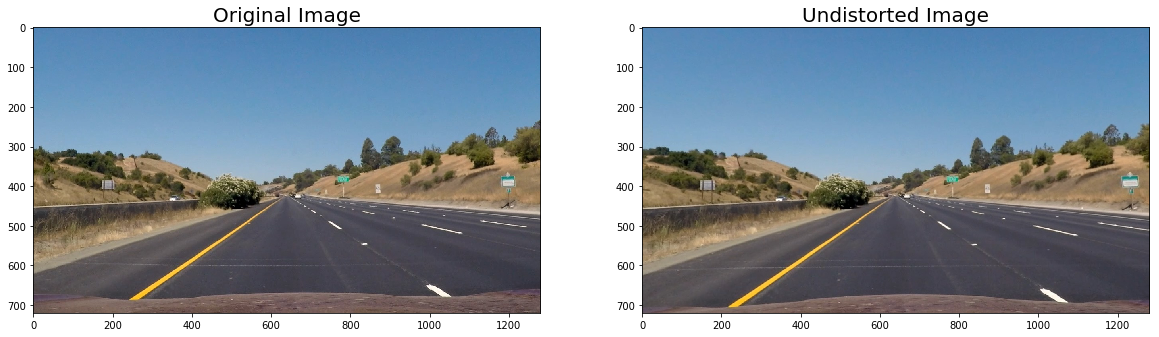

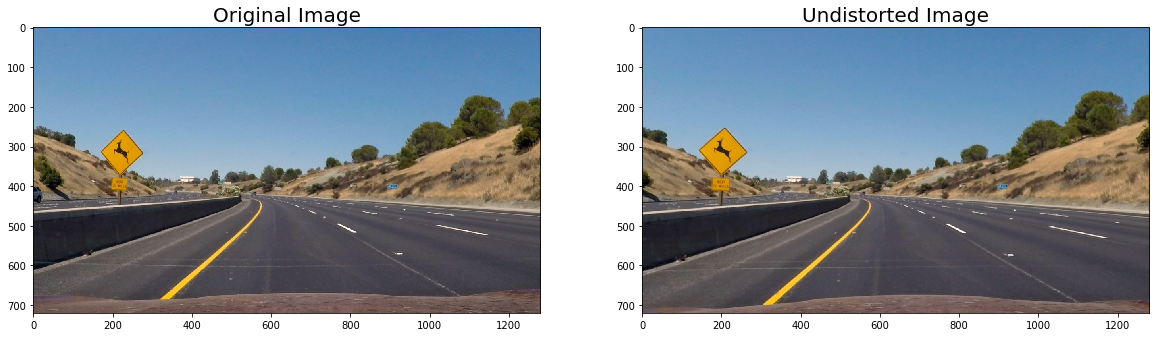

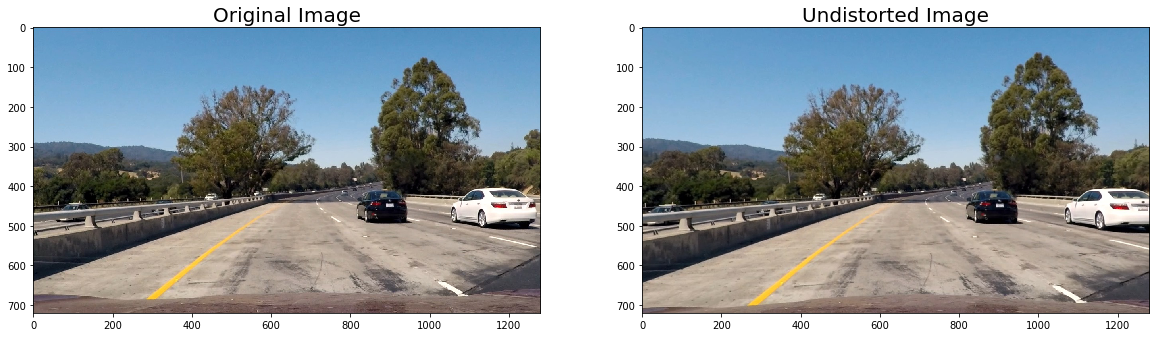

In [4]:
import pickle
# Read pickle
file = open("wide_dist_pickle.p",'rb')
object_file = pickle.load(file)
file.close()

test_images = glob.glob('test_images/*.jpg')
for test_img in test_images:
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    dst = cv2.undistort(img, object_file['mtx'], object_file['dist'], None, object_file['mtx'])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)



## Cool, now we have done undistortion let's work our through separating lane lines 


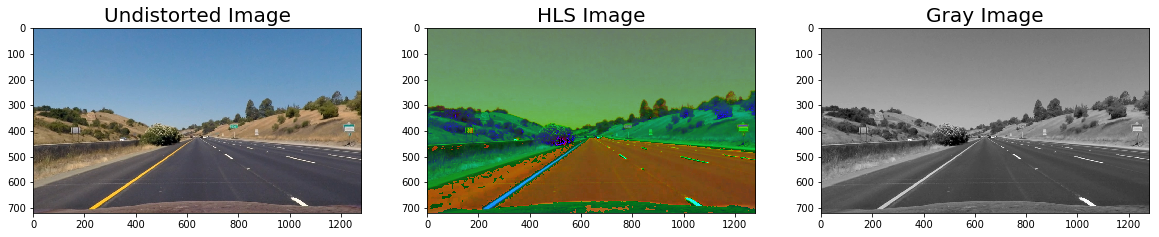

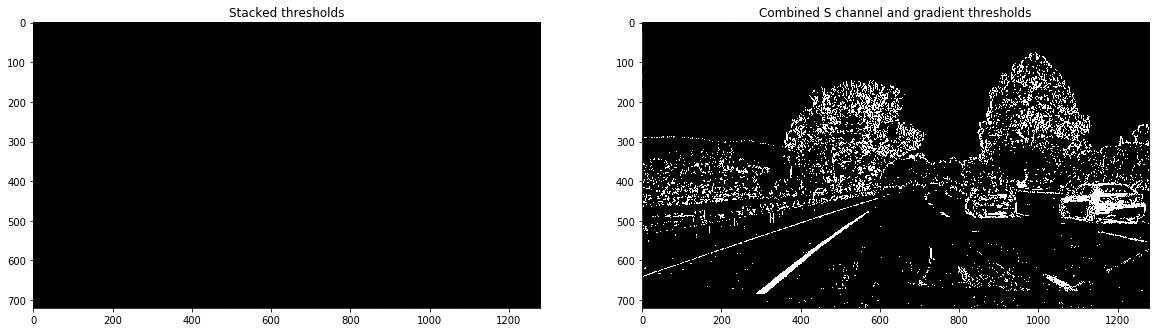

In [63]:
dst = mpimg.imread("test_images/straight_lines1.jpg")
dst = cv2.undistort(dst, object_file['mtx'], object_file['dist'], None, object_file['mtx'])
hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(hls,cmap='gray')
ax2.set_title('HLS Image', fontsize=20)
ax3.imshow(gray,cmap='gray')
ax3.set_title('Gray Image',fontsize=20)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Now let's find points for performing perspective transform

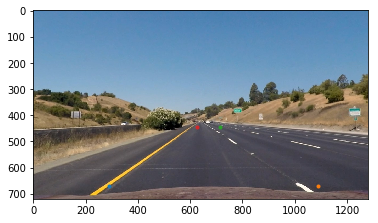

In [64]:
# Invoke interactive window for performing this 
% matplotlib inline
plt.imshow(dst)
points = [[290,672],[1090,672],[713,440],[627,444]]
pts = np.array([[10,5],[20,30],[70,20],[50,10]], np.int32)
pts = np.array(points,np.int32)
pts = pts.reshape((-1,1,2))
alter = [[375, 480],[905, 480],[1811, 685],[-531, 685]]
alternate = np.array(alter,np.int32)
alternate = alternate.reshape((-1,1,2))
#cv2.polylines(dst,[alternate],True,(0,255,255))
plt.plot(290,672,'.')
plt.plot(1090,672,'.')
plt.plot(713,444,'.')
plt.plot(627,444,'.')
plt.imshow(dst)

## Now let's perform perspective transform



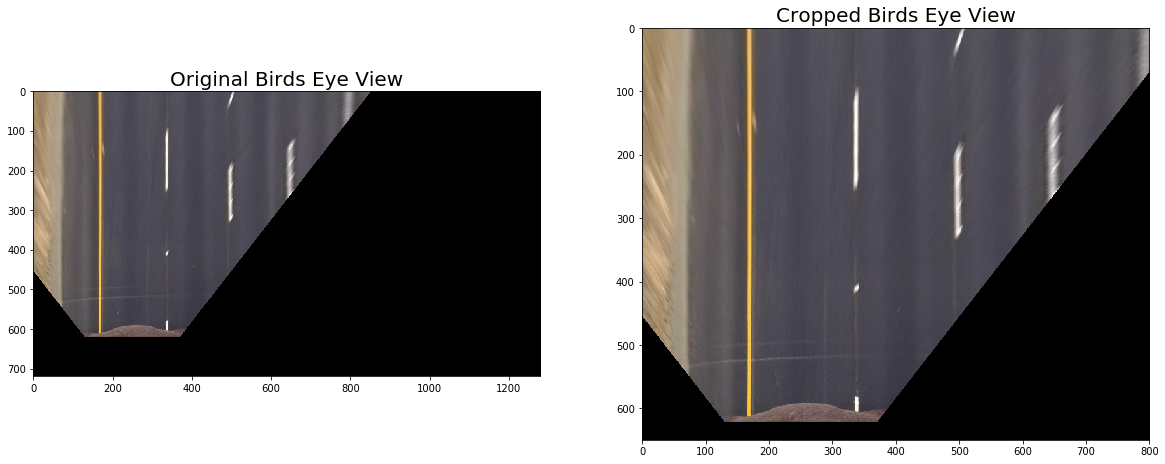

In [65]:
def wrap(img,fit=False):
    if fit:
        img_size = (800,650)
    else:
        img_size = (img.shape[1],img.shape[0])
    src = np.float32([[375, 480],[905, 480],[1811, 685],[-531, 685]])
    #src = np.float32([[290,672],[1090,672],[713,440],[627,444]])
    dst = np.float32([[0,0],[500,0],[500,600],[0,600]])
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img,M,img_size)
    return warped

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(wrap(dst))
ax1.set_title('Original Birds Eye View', fontsize=20)
ax2.imshow(wrap(dst,fit=True))
ax2.set_title('Cropped Birds Eye View', fontsize=20)